In [1]:
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
# Load camera matrix and distortion coefficients calculated in ./Camera-Calibration.ipynb
mtx = np.load('data/mtx.npy')
dist = np.load('data/dist.npy')

### Load images

In [3]:
import glob

test_files = glob.glob('test_images/*.jpg')
test_imgs = []
for file in test_files:
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    test_imgs.append(np.flip(img, 2)) # opencv uses bgr instead of rgb

In [4]:
# Images that we failed to detect lane linse in ./Lane-Lines.ipynb
broken_images = np.load('broken_images/broken_images.npy')
broken_images_challenge = np.load('broken_images/broken_challenge_images_1.npy')
broken_images_orig = np.load('broken_images/broken_images_old_1.npy')

### Undistort test images

In [5]:
def undistort_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    

In [6]:
undistorted_imgs = []
for img in test_imgs:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_imgs.append(dst)

### Gradient Thresholding

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel_thresh(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return gradx, grady, mag_binary, dir_binary, combined.astype(np.uint8)


#### Test out gradient Thresholding

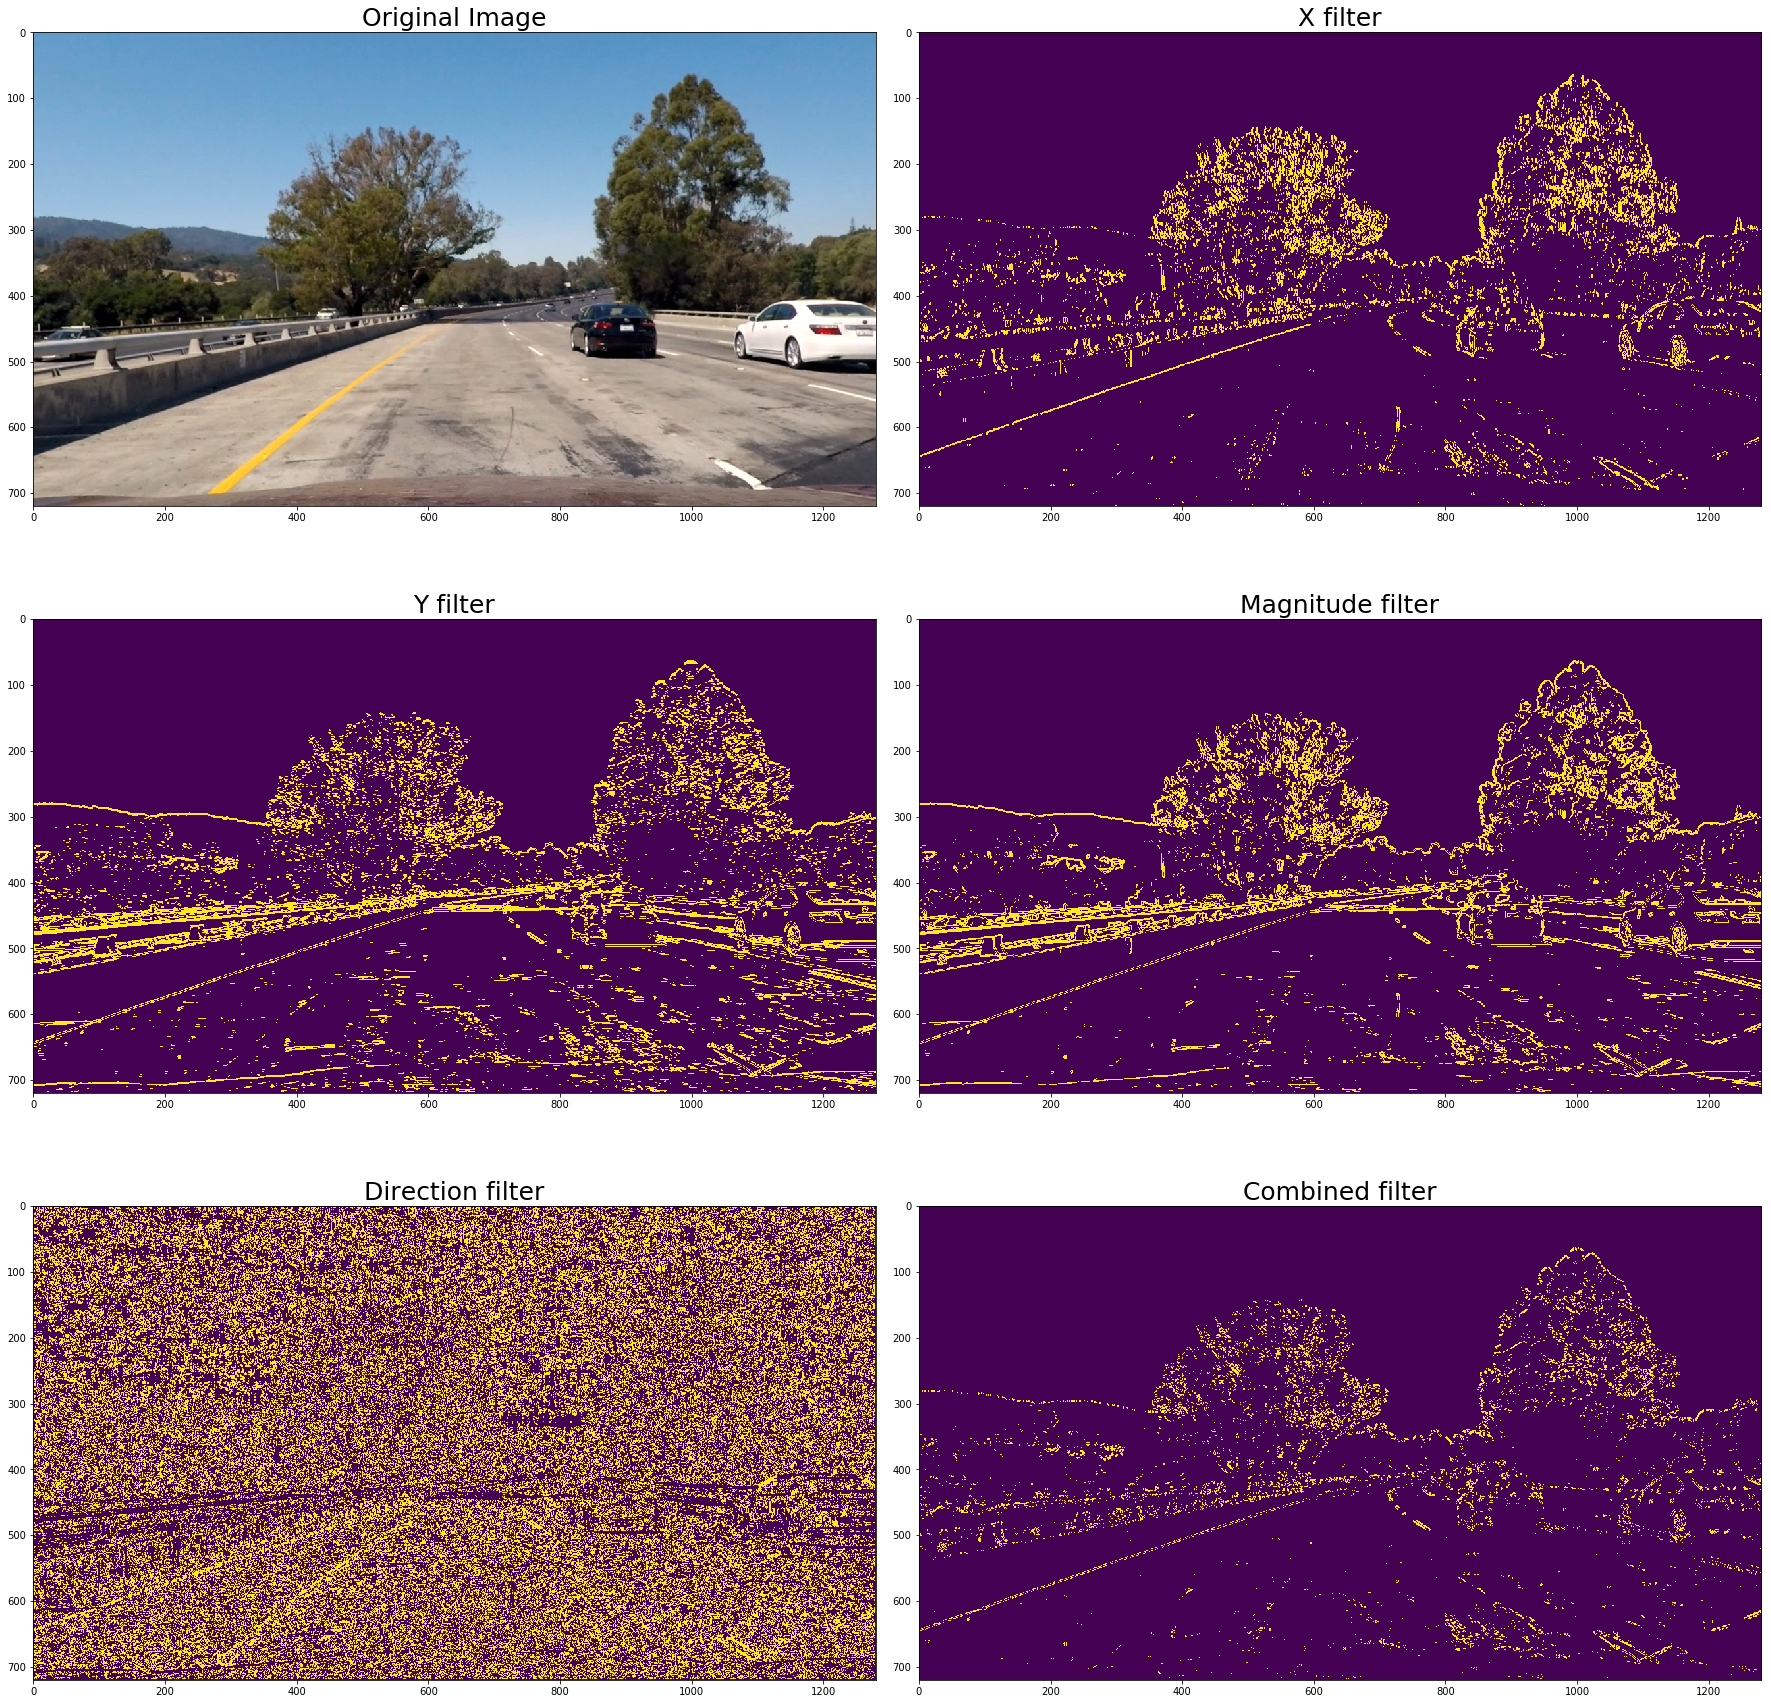

In [8]:
def plot_gradient_thresholds(image):
    gradx, grady, mag_binary, dir_binary, combined = combined_sobel_thresh(image)
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(24, 24))
    f.tight_layout()
    ax1[0].imshow(image)
    ax1[0].set_title('Original Image', fontsize=25)
    ax1[1].imshow(gradx)
    ax1[1].set_title('X filter', fontsize=25)
    ax2[0].imshow(grady)
    ax2[0].set_title('Y filter', fontsize=25)
    ax2[1].imshow(mag_binary)
    ax2[1].set_title('Magnitude filter', fontsize=25)
    ax3[0].imshow(dir_binary)
    ax3[0].set_title('Direction filter', fontsize=25)
    ax3[1].imshow(combined)
    ax3[1].set_title('Combined filter', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
    f.savefig('examples/user_added/gradient_threshold_imgs.png')
    
color_img = undistorted_imgs[2]
plot_gradient_thresholds(color_img)

### Color Thresholding

In [9]:
def color_threshold(img, color_model, low, high):
    hls = cv2.cvtColor(img, color_model)
    
    channel_thresh_img = np.zeros_like(img)
    hsv_binary = np.zeros(img.shape[:1])
    for i in range(img.shape[-1]):
        idx = (hls[...,i] >= low[i]) & (hls[...,i] <= high[i])
        channel_thresh_img[idx, i] = 1
    hsv_binary = channel_thresh_img[..., 0] & channel_thresh_img[..., 1] & channel_thresh_img[..., 2]
    return hsv_binary

def combined_color_thresh(img):
    hls_img_y = color_threshold(img, cv2.COLOR_RGB2HLS, [0,100,90], [40,255,255])
    lab_img_y = color_threshold(img, cv2.COLOR_RGB2LAB, [0,0,155], [255,255,200])
    luv_img_w = color_threshold(img, cv2.COLOR_RGB2LUV, [210,0,0], [255,255,255])
    
    combined = np.zeros_like(hls_img_y)
    for img in [hls_img_y, lab_img_y, luv_img_w]:
        combined = combined | img
    return hls_img_y, lab_img_y, luv_img_w, combined.astype(np.uint8)


### Test out Color Thresholding

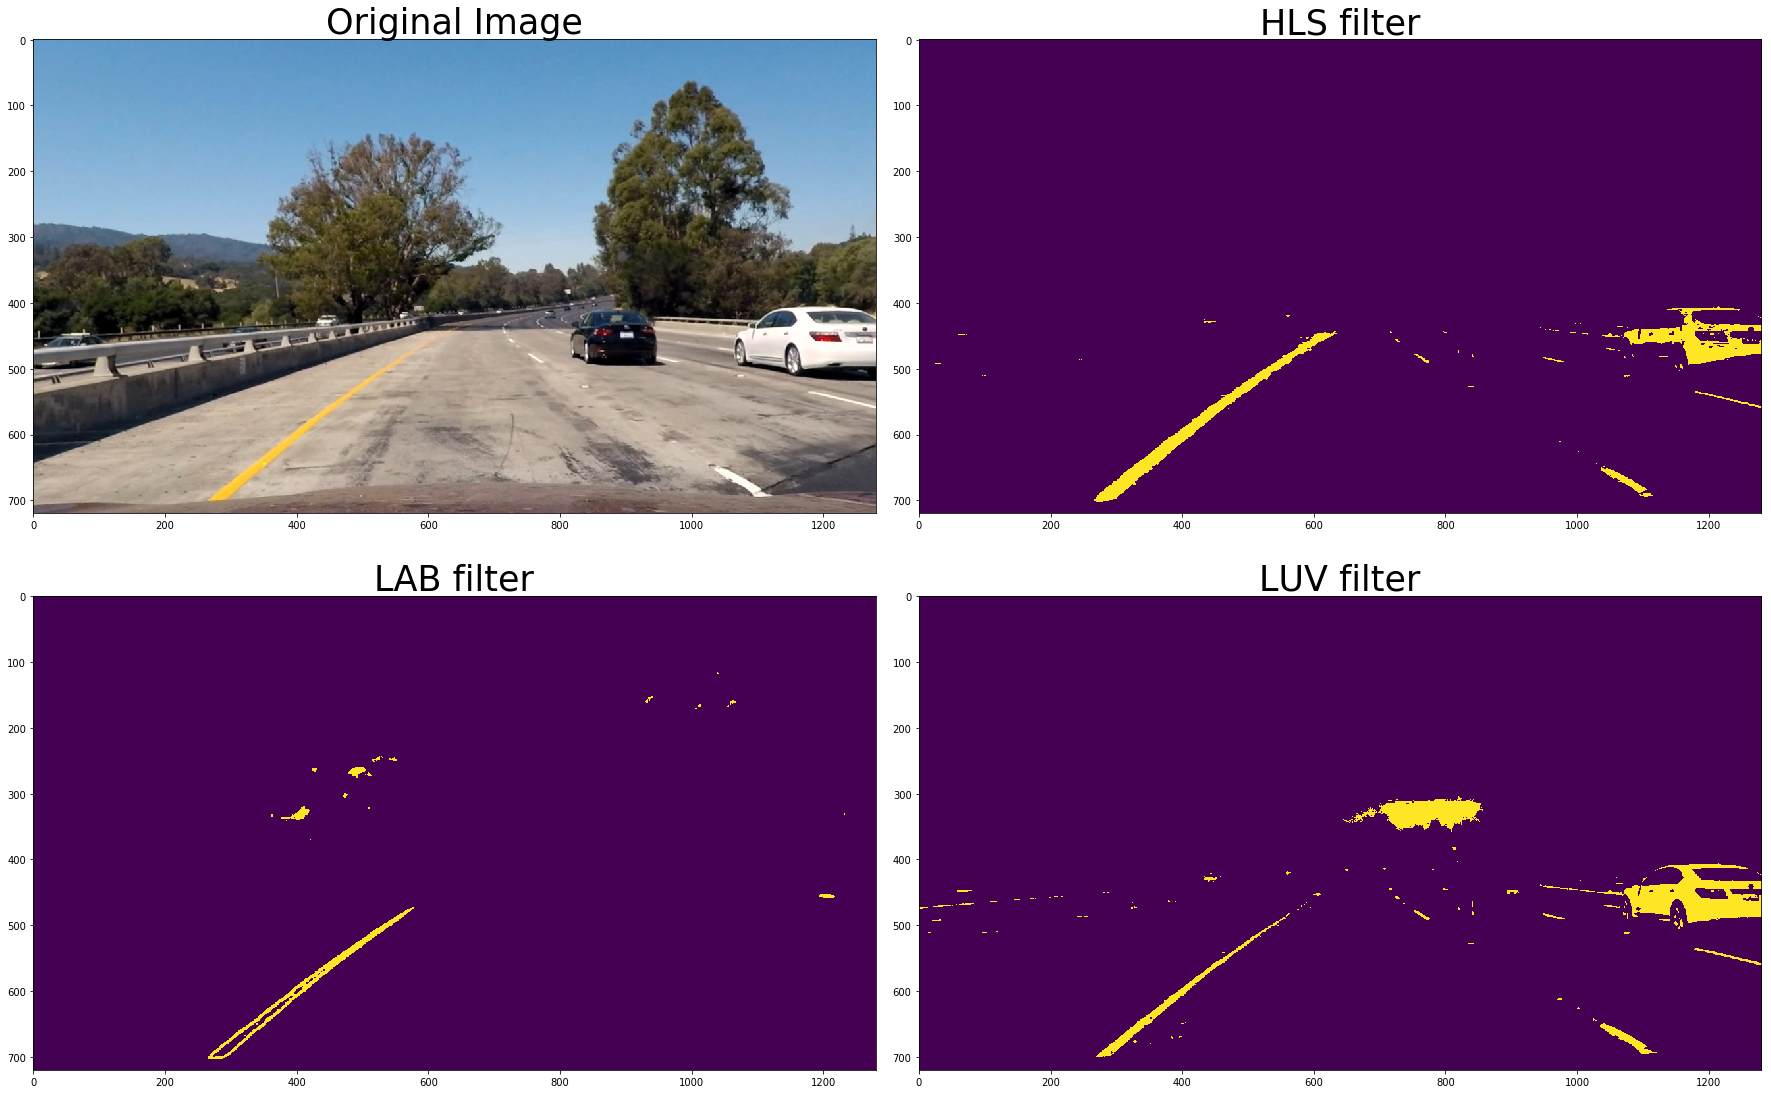

In [10]:
# color_img = broken_images_orig[10]
# color_img = broken_images[-1]
color_img = undistorted_imgs[2]

def plot_color_threshold(img):
    hls_img_y, lab_img_y, luv_img_w, combined = combined_color_thresh(img)

    f, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 15))
    f.tight_layout()
    ax1[0].imshow(img)
    ax1[0].set_title('Original Image', fontsize=35)
    ax1[1].imshow(hls_img_y)
    ax1[1].set_title('HLS filter', fontsize=35)
    ax2[0].imshow(lab_img_y)
    ax2[0].set_title('LAB filter', fontsize=35)
    ax2[1].imshow(luv_img_w)
    ax2[1].set_title('LUV filter', fontsize=35)
    plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
    f.savefig('examples/user_added/color_threshold_imgs.png')
    
    
plot_color_threshold(color_img)

### Combine Gradient and Color thresholded images

In [11]:
def combined_thresh(sobel_binary, color_binary):
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary == 1) | (color_binary == 1)] = 1
    return combined_binary.astype(np.uint8)

def threshold_image(img):
    ,,,,sobel_binary = combined_sobel_thresh(img)
    color_binary = combined_color_thresh(img)
    return combined_thresh(sobel_binary, color_binary)

def plot_threshold(sobel_binary, color_binary, original):    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, color_binary)) * 255
    
    combined_binary = combined_thresh(sobel_binary, color_binary)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(stacked_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    
    f.savefig('examples/user_added/threshold_compare.png')

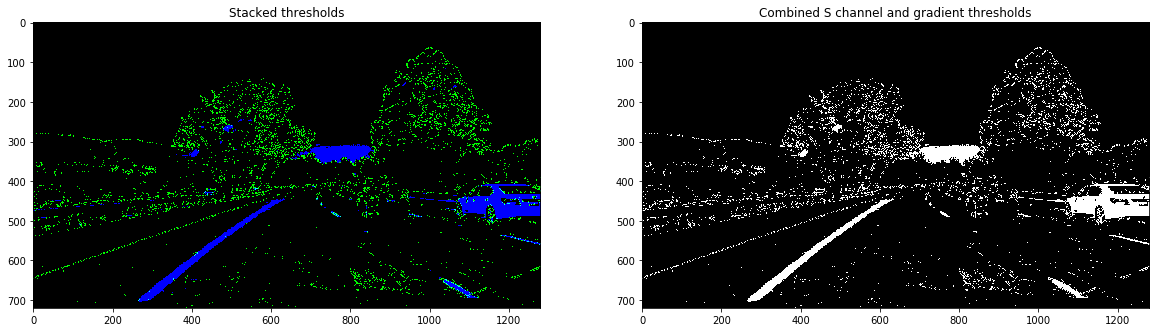

In [12]:
show_img = undistorted_imgs[2]
# show_img = broken_images[10]

_,_,_,_,sobel_binary = combined_sobel_thresh(show_img)
_,_,_,color_binary = combined_color_thresh(show_img)
combined_binary = combined_thresh(sobel_binary, color_binary)
plot_threshold(sobel_binary, color_binary, show_img)

### Challenge video - Dealing with shadows

#### Equalized image with shadows (challenge problem)

In [13]:
# Different thresholds for when image is equalized
def combined_color_thresh_eq(img):
    h_eq_img = img_histogram_eq(img)
    yellow = hls_threshold(h_eq_img, [0,100,100], [50,255,255]) # yellow
    blue = hls_threshold(h_eq_img, [0,150,170], [255, 255, 255]) # white
    comb = np.zeros_like(yellow)
    comb = blue | yellow
    return comb

def img_histogram_eq(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return img_output

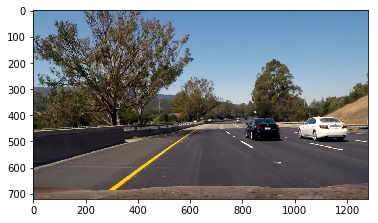

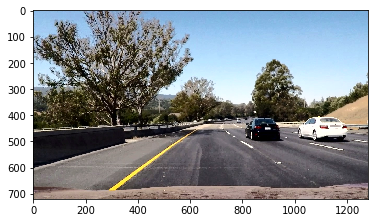

In [14]:
def plt_eq(img):
    # convert the YUV image back to RGB format
    img_output = img_histogram_eq(img)

    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(img_output)
    
# img = broken_image_challenge[10]
plt_eq(img)